## Prepare imports

In [1]:
from datasets.topological import DataModule, DataModuleConfig
import torch
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pyvista as pv

from torch_geometric.data import Batch

from models.vae import VanillaVAE
from models.vae import BaseModel as BaseVAE
from models.encoder import BaseModel as EctEncoder
from layers.ect import EctLayer, EctConfig

from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from metrics.loss import compute_mse_loss_fn
from layers.directions import generate_directions

from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt

from models.vae import VanillaVAE,BaseModel
from metrics.metrics import get_mse_metrics
from metrics.accuracies import compute_mse_accuracies
from layers.ect import EctLayer, EctConfig

from metrics.loss import compute_mse_kld_loss_fn


DEVICE = "cuda:0"

vae_config = OmegaConf.load("./configs/config_vae_topological.yaml")
ectencoder_config = OmegaConf.load("./configs/config_encoder_topological.yaml")
dm = DataModule(DataModuleConfig())


## Load Models and Data

In [2]:
layer = EctLayer(
    EctConfig(
        num_thetas=ectencoder_config.layer.ect_size,
        bump_steps=ectencoder_config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_directions(ectencoder_config.layer.ect_size, ectencoder_config.layer.dim, DEVICE),
)

# Load the encoder 

ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/ectencoder_topological.ckpt",
    layer=layer,
    ect_size=ectencoder_config.layer.ect_size,
    hidden_size=ectencoder_config.model.hidden_size,
    num_pts=ectencoder_config.model.num_pts,
    num_dims=ectencoder_config.model.num_dims,
    learning_rate=ectencoder_config.model.learning_rate,
).to(DEVICE)

vae_model = VanillaVAE(
    in_channels=vae_config.model.in_channels,
    latent_dim=vae_config.model.latent_dim,
    img_size=vae_config.layer.ect_size,
)

# Load the VAE model

metrics = get_mse_metrics()

vae_litmodel = BaseModel.load_from_checkpoint(
    f"./trained_models/{vae_config.model.save_name}",
    model=vae_model,
    training_accuracy=metrics[0],
    test_accuracy=metrics[1],
    validation_accuracy=metrics[2],
    accuracies_fn=compute_mse_accuracies,
    loss_fn=compute_mse_kld_loss_fn,
    learning_rate=vae_config.litmodel.learning_rate,
    layer=layer,
).to(DEVICE)


## Generate an ECT and use VAE as autoencoder to recreate the ECT

In [3]:
# batch_len = len(dm.test_dataloader())
test_ds = dm.test_ds

# For each class, grab 16 samples.
mfld_classes = test_ds.y.unique() 

test_data_list = []

for idx in mfld_classes: 
    test_data_list.extend([test_ds[test_ds.y == idx][i] for i in range(16)])


test_batch = Batch.from_data_list(test_data_list).to(DEVICE)
points_batch = test_batch.x.cpu().detach().view(-1,1024,3).numpy()


# Visualize original point cloud

In [4]:
pl = pv.Plotter(shape=(8, 8), window_size=[1600, 1600],border=False,polygon_smoothing=True)

for row in range(8):
    for col in range(8):
        points = points_batch[8*row + col].reshape(-1, 3)
        pl.subplot(row, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=5,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )


pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
# pl.screenshot("./figures/reconstructed_topological/reconstructed_pointcloud.png",transparent_background=True,scale=2)
pl.show()
# path = pl.generate_orbital_path(n_points=64, shift=2, factor=3.0)
# p0l.open_gif("./figures/reconstructed_topological/orbit_cloud.gif")
# pl.orbit_on_path(path, write_frames=True)
# pl.close()


Widget(value='<iframe src="http://localhost:55522/index.html?ui=P_0x2b32704d210_0&reconnect=auto" class="pyvis…

# Reconstructed point cloud

In [5]:
ect = layer(test_batch,test_batch.batch).unsqueeze(1)


with torch.no_grad():
    decoded = ect_encoder_litmodel.model.forward(ect)


import pyvista as pv

pl = pv.Plotter(shape=(8, 8), window_size=[1600, 1600],border=False,polygon_smoothing=True)

batch = decoded.cpu().detach().numpy()


for row in range(8):
    for col in range(8):
        points = batch[8*row + col].reshape(-1, 3)
        pl.subplot(row, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=5,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )



pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
# pl.screenshot("./figures/img/reconstructed_topological/reconstructed_pointcloud.png",transparent_background=True,scale=2)
# pl.show()

# pl.background_color = "w"
# pl.link_views()
# pl.camera_position = "yz"
# pos = pl.camera.position
# pl.camera.position = (pos[0],pos[1],pos[2]+3)
# pl.camera.azimuth = -45
# pl.camera.elevation = 10

# # create a top down light
# light = pv.Light(position=(0, 0, 3), positional=True,
#                 cone_angle=50, exponent=20, intensity=.2)
# pl.add_light(light)
# pl.camera.zoom(1.3)
# pl.screenshot("./figures/reconstructed_topological/reconstructed_pointcloud.png",transparent_background=True,scale=2)
# pl.show()
# path = pl.generate_orbital_path(n_points=64, shift=2, factor=3.0)
# pl.open_gif("./figures/reconstructed_topological/orbit_cloud.gif")
# pl.orbit_on_path(path, write_frames=True)
# pl.close()


## Sample from VAE and reconstruct points 

In [6]:

with torch.no_grad():
    decoded, theinput, z_mean, z_log_var = vae_litmodel.forward(ect)

# Undo the VAE transform
decoded = (decoded + 1 ) / 2

with torch.no_grad():
    batch_decoded = ect_encoder_litmodel.model.forward(decoded)



In [7]:

import pyvista as pv

pl = pv.Plotter(shape=(8, 8), window_size=[1600, 1600],border=False,polygon_smoothing=True)

batch_decoded = batch_decoded.cpu().detach().numpy()


for row in range(8):
    for col in range(8):
        points = batch_decoded[8*row + col].reshape(-1, 3)
        pl.subplot(row, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=5,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )



pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.screenshot("./figures/img/topological/reconstructed_vae_pointcloud.png",transparent_background=True,scale=2)
pl.show()


Widget(value='<iframe src="http://localhost:55522/index.html?ui=P_0x2b32704d540_2&reconnect=auto" class="pyvis…

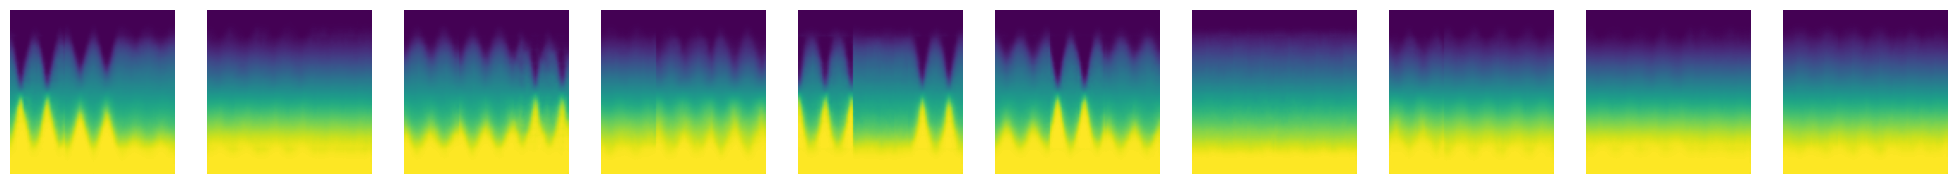

In [8]:
samples = vae_litmodel.model.sample(64, "cuda:0")

n_images = 10

fig, axes = plt.subplots(
    nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(25,5)
)

for sample, ax in zip(samples,axes.T):
    ax.imshow(sample.cpu().detach().squeeze().numpy())
    ax.axis("off")

plt.savefig("./figures/img/topological/generated_ect.png",transparent=True)

In [9]:

import pyvista as pv

pl = pv.Plotter(shape=(8, 8), window_size=[1600, 1600],border=False,polygon_smoothing=True)


# Undo the VAE transform
samples = (samples + 1 ) / 2

with torch.no_grad():
    batch_decoded = ect_encoder_litmodel.model.forward(samples)



batch_decoded = batch_decoded.cpu().detach().numpy()


for row in range(8):
    for col in range(8):
        points = batch_decoded[8*row + col].reshape(-1, 3)
        pl.subplot(row, col)
        actor = pl.add_points(
            points,
            style="points",
            emissive=False,
            show_scalar_bar=False,
            render_points_as_spheres=True,
            scalars=points[:, 2],
            point_size=5,
            ambient=0.2, 
            diffuse=0.8, 
            specular=0.8,
            specular_power=40, 
            smooth_shading=True
        )



pl.background_color = "w"
pl.link_views()
pl.camera_position = "yz"
pos = pl.camera.position
pl.camera.position = (pos[0],pos[1],pos[2]+3)
pl.camera.azimuth = -45
pl.camera.elevation = 10

# create a top down light
light = pv.Light(position=(0, 0, 3), positional=True,
                cone_angle=50, exponent=20, intensity=.2)
pl.add_light(light)
pl.camera.zoom(1.3)
pl.screenshot("./figures/img/topological/generated_pointcloud.png",transparent_background=True,scale=2)
pl.show()

Widget(value='<iframe src="http://localhost:55522/index.html?ui=P_0x2b4b82c5390_3&reconnect=auto" class="pyvis…